In [1]:
import numpy as np
import pandas as pd

from sklearn.decomposition import PCA
import prince

import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms
import seaborn as sns
sns.set_theme() # I like seaborn default theme

from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster

from statsmodels.api import qqplot

import warnings
warnings.filterwarnings('ignore')

input_path = './data/'
sp500_px = pd.read_csv(input_path + 'sp500_data.csv.gz',
                       index_col=0)
housetasks = pd.read_csv(input_path + 'housetasks.csv',
                         index_col=0)

# 7 Unsupervised Learning

The term *unsupervised learning* refers to statistical methods that extract meaning from data without training a model on labeled data (data where an outcome of interest is known). 

## 7.1 Principal Components Analysis (PCA)

#### <center>Key Terms for Principal Components Analysis</center>
- ***Principal component***  
A linear combination of the predictor variables.
- ***Loadings***  
The weights that transform the predictors into the components.<br>  
*Synonym*
    - Weights
- ***Screeplot***  
A plot of the variances of the components, showing the relative importance of the components, either as explained variance or as proportion of explained variance.

### Explain

For two variables, $X_1$ and $X_2$, there are two principal components $Z_i$ ($i$ = 1 or 2):
$$Z_i = w_{i,1}X_1 + w_{i,2}X_2$$
The weights ($w_{i,1}$, $w_{i,2}$) are known as the component *loadings*. These transform the original variables into the principal components. The first principal component, $Z_1$, is the linear combination that best explains the total variation. The second principal component, $Z_2$, is orthogonal to the first and explains as much of the remaining variation as it can. (If there were additional components, each additional one would be orthogonal to the others.)

### Example

The following performs a PCA on the stock price returns for Chevron (CVX) and ExxonMobil (XOM):

In [2]:
oil_px = sp500_px[['CVX', 'XOM']]
pca = PCA(n_components=2)
pca.fit(oil_px)
loadings = pd.DataFrame(pca.components_, columns=oil_px.columns)
loadings

,CVX,XOM
0,-0.747101,-0.664711
1,-0.664711,0.747101


The weights for CVX and XOM for the first principal component are –0.747 and –0.665, and for the second principal component they are -0.665 and 0.747. How to interpret this? The first principal component is essentially an average of CVX and XOM, reflecting the correlation between the two energy companies. The second principal component measures when the stock prices of CVX and XOM diverge.

It is instructive to plot the principal components with the data.

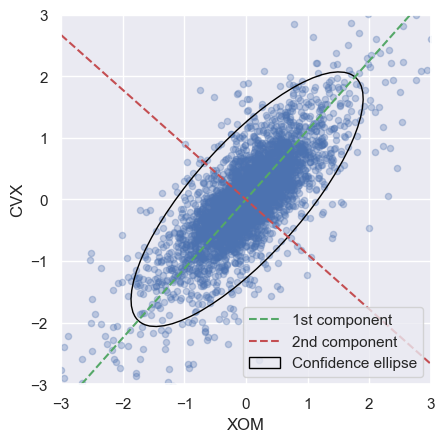

In [3]:
def confidence_ellipse(x, y, ax, n_std=3.0, facecolor='none', **kwargs):
    """
    Create a plot of the covariance confidence ellipse of *x* and *y*.

    Parameters
    ----------
    x, y : array-like, shape (n, )
        Input data.

    ax : matplotlib.axes.Axes
        The axes object to draw the ellipse into.

    n_std : float
        The number of standard deviations to determine the ellipse's radiuses.

    **kwargs
        Forwarded to `~matplotlib.patches.Ellipse`

    Returns
    -------
    matplotlib.patches.Ellipse
    """
    if x.size != y.size:
        raise ValueError("x and y must be the same size")

    cov = np.cov(x, y)
    pearson = cov[0, 1]/np.sqrt(cov[0, 0] * cov[1, 1])
    # Using a special case to obtain the eigenvalues of this
    # two-dimensional dataset.
    ell_radius_x = np.sqrt(1 + pearson)
    ell_radius_y = np.sqrt(1 - pearson)
    ellipse = Ellipse((0, 0), width=ell_radius_x * 2, height=ell_radius_y * 2,
                      facecolor=facecolor, **kwargs)

    # Calculating the standard deviation of x from
    # the squareroot of the variance and multiplying
    # with the given number of standard deviations.
    scale_x = np.sqrt(cov[0, 0]) * n_std
    mean_x = np.mean(x)

    # calculating the standard deviation of y ...
    scale_y = np.sqrt(cov[1, 1]) * n_std
    mean_y = np.mean(y)

    transf = transforms.Affine2D() \
        .rotate_deg(45) \
        .scale(scale_x, scale_y) \
        .translate(mean_x, mean_y)

    ellipse.set_transform(transf + ax.transData)
    return ax.add_patch(ellipse)

ax = oil_px.plot.scatter(x='XOM', y='CVX', alpha=0.3)
ax.set_xlim(-3, 3)
ax.set_ylim(-3, 3)
ax.axline(
    (0, 0),
    slope = loadings.loc[0, 'CVX'] / loadings.loc[0, 'XOM'],
    ls = '--',
    color = 'C2',
    label = '1st component'
)
ax.axline(
    (0, 0),
    slope = loadings.loc[1, 'CVX'] / loadings.loc[1, 'XOM'],
    ls = '--',
    color = 'C3',
    label = '2nd component'
)
confidence_ellipse(oil_px['XOM'], oil_px['CVX'], ax,
                   edgecolor='black', label='Confidence ellipse')
plt.legend(loc='lower right')
ax.set_aspect('equal')

The dashed lines show the direction of the two principal components: the first one is along the long axis of the ellipse, and the second one is along the short axis. You can see that a majority of the variability in the two stock returns is explained by the first principal component. This makes sense since energy stock prices tend to move as a group.

### Computing the Principal Components

Going from two variables to more variables is straightforward:  
1. In creating the first principal component, PCA arrives at the linear combination of predictor variables that maximizes the percent of total variance explained.
2. This linear combination then becomes the first “new” predictor, $Z_1$.
3. PCA repeats this process, using the same variables with different weights, to create a second new predictor, $Z_2$. The weighting is done such that $Z_1$ and $Z_2$ are uncorrelated.
4. The process continues until you have as many new variables, or components, $Z_1$ as original variables $X_1$.
5. Choose to retain as many components as are needed to account for most of the variance.
6. The result so far is a set of weights for each component. The final step is to convert the original data into new principal component scores by applying the weights to the original values. These new scores can then be used as the reduced set of predictor variables.

### Interpreting Principal Components

Use *screeplot* to visualize the relative importance of principal components (the name derives from the resemblance of the plot to a scree slope; here, the y-axis is the eigenvalue).

Below code shows an example for a few top companies in the S&P 500:

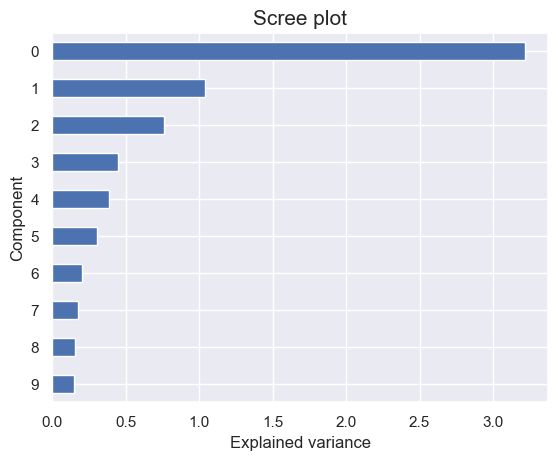

In [4]:
syms = sorted(['AAPL', 'MSFT', 'CSCO', 'INTC', 'CVX', 'XOM', 'SLB', 'COP',
               'JPM', 'WFC', 'USB', 'AXP', 'WMT', 'TGT', 'HD', 'COST'])
top_sp = sp500_px.loc[sp500_px.index >= '2011-01-01', syms]

sp_pca = PCA()
sp_pca.fit(top_sp)

explained_variance = pd.DataFrame(sp_pca.explained_variance_)
ax = explained_variance.head(10).plot.barh(legend=False)
ax.set_xlabel('Explained variance')
ax.set_ylabel('Component')
ax.set_title('Scree plot', fontsize=15)
ax.invert_yaxis()
plt.show()

It can be especially revealing to plot the weights of the top principal components.

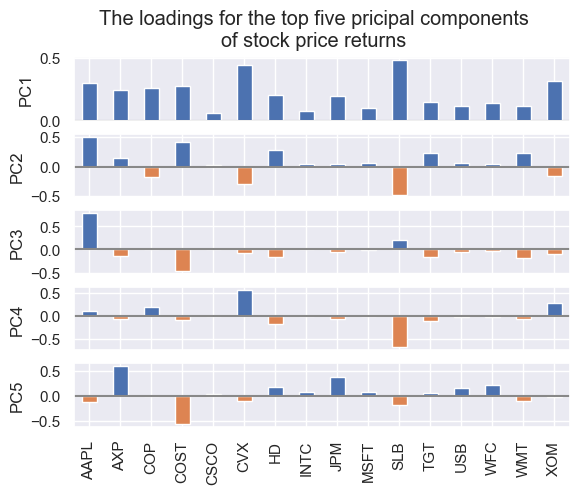

In [5]:
loadings = pd.DataFrame(sp_pca.components_[0:5, :], 
                        columns=top_sp.columns)

f, axes = plt.subplots(5, 1, sharex=True)
for i, ax in enumerate(axes):
    pc_loadings = -loadings.loc[i, :]
    colors = ['C0' if l > 0 else 'C1' for l in pc_loadings]
    ax.axhline(0, color='#888888')
    pc_loadings.plot.bar(ax=ax, color=colors)
    ax.set_ylabel(f'PC{i+1}')
f.suptitle('The loadings for the top five pricipal components\nof stock price returns')
plt.show()

The loadings for the first principal component have the same sign: this is typical for data in which all the columns share a common factor (in this case, the overall stock market trend). The second component captures the price changes of energy stocks as compared to the other stocks. The third component is primarily a contrast in the movements of Apple and CostCo. The fourth component contrasts the movements of Schlumberger (SLB) to the other energy stocks. Finally, the fifth component is mostly dominated by financial companies.

### Correspondence Analysis

PCA cannot be used for categorical data; however, a somewhat related technique is *correspondence analysis*. The goal is to recognize associations between categories, or between categorical features.

Here is a very good article explaining how to calculate and interprete correspondence analysis: --> [Link](https://www.qualtrics.com/eng/correspondence-analysis-what-is-it-and-how-can-i-use-it-to-measure-my-brand-part-1-of-2/?utm_source=pocket_reader)

In [6]:
ca = prince.CA(n_components=2)
ca = ca.fit(housetasks)

ca.plot(housetasks, show_column_labels=True, show_row_labels=True)

alt.LayerChart(...)

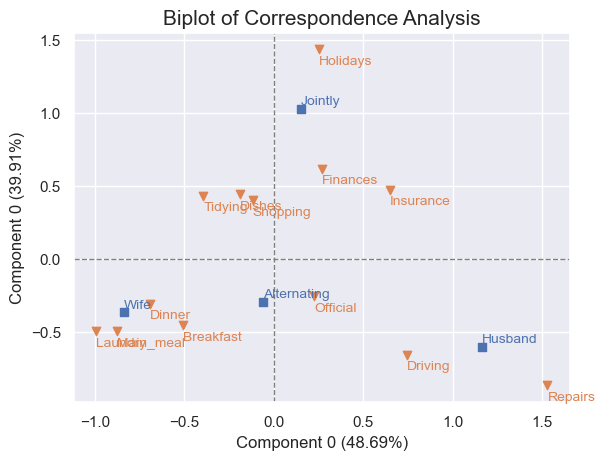

In [7]:
col_corr = ca.column_coordinates(housetasks)
row_corr = ca.row_coordinates(housetasks)
plt.axhline(0, c='.5', ls='--', linewidth=1)
plt.axvline(0, c='.5', ls='--', linewidth=1)
plt.scatter(col_corr.iloc[:,0], col_corr.iloc[:,1], 
            c='C0', marker='s')
plt.scatter(row_corr.iloc[:,0], row_corr.iloc[:,1], 
            c='C1', marker='v')
for i in range(len(col_corr)):
    text = col_corr.index[i]
    x = col_corr.iloc[i,0]
    y = col_corr.iloc[i,1]
    plt.annotate(text, (x, y+.03), c='C0', fontsize=10)
for i in range(len(row_corr)):
    text = row_corr.index[i]
    x = row_corr.iloc[i,0]
    y = row_corr.iloc[i,1]
    plt.annotate(text, (x, y-.1), c='C1', fontsize=10)
plt.title('Biplot of Correspondence Analysis', fontsize=15)
plt.xlabel(f'Component 0 ({ca.eigenvalues_summary.iloc[0,1]})')
plt.ylabel(f'Component 0 ({ca.eigenvalues_summary.iloc[1,1]})')
plt.show()

## 7.2 K-Means Clustering

#### <center>Key Terms for K-Means Clustering</center>
- ***Cluster***  
A group of records that are similar.
- ***Cluster mean***  
The vector of variable means for the records in a cluster.
- ***K***  
The number of clusters.

*K*-means divides the data into *K* clusters by minimizing the sum of the squared distances of each record to the *mean* of its assigned cluster. This is referred to as the *within-cluster sum of squares or within-cluster SS*. 

It is easy to find the detailed algorithm of *K*-Means online, I will not put here. It is important that the variables need to be scaled (e.g. stadardize) before grouping. We tell the model the importance of each variable thorough scaling. If all variables are standardize scaled, they show same significance in the model.

K-Means Clustering can be used to engineer new feature for more sophisticated learning model.

### Example

Suppose we want to divide daily stock returns into four groups. K-means clustering can be used to separate the data into the best groupings. Note that daily stock returns are reported in a fashion that is, in effect, standardized, so we do not need to normalize the data. The following finds four clusters based on two variables—the daily stock returns for ExxonMobil (XOM) and Chevron (CVX):

In [8]:
df = sp500_px.loc[sp500_px.index >= '2011-01-01', ['XOM', 'CVX']]
kmeans = KMeans(n_clusters=4, random_state=314).fit(df)

df['cluster'] = kmeans.labels_
df.head()

,XOM,CVX,cluster
2011-01-03,0.736805,0.240681,0
2011-01-04,0.168668,-0.584516,3
2011-01-05,0.026631,0.446985,0
2011-01-06,0.248558,-0.919751,3
2011-01-07,0.337329,0.180511,0


The first 5 records are assigned to either cluster 0 or cluster 3. Below codes show the center (means) of the clusters.

In [9]:
centers = pd.DataFrame(kmeans.cluster_centers_, columns=['XOM', 'CVX'])
centers

,XOM,CVX
0,0.298493,0.395241
1,-1.123045,-1.718845
2,1.009182,1.489102
3,-0.303987,-0.515509


Clusters 1 and 3 represent "down" markets, while clusters 0 and 2 represent "up" markets.

In this example, with just two variables, it is straightforward to visualize the clusters and their means:

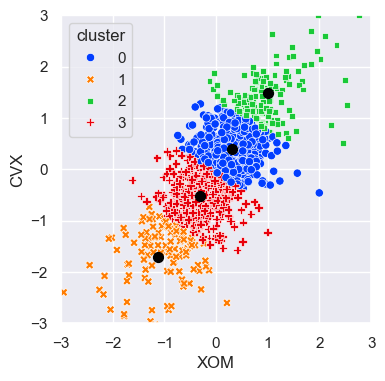

In [10]:
fig, ax = plt.subplots(figsize=(4, 4))
ax = sns.scatterplot(x='XOM', y='CVX', hue='cluster', style='cluster',
                     palette='bright', ax=ax, data=df)
ax.set_xlim(-3, 3)
ax.set_ylim(-3, 3)
centers.plot.scatter(x='XOM', y='CVX', ax=ax, s=50, color='black')
plt.show()

Now we try with more variables:

In [11]:
syms = sorted(['AAPL', 'MSFT', 'CSCO', 'INTC', 'CVX', 'XOM', 'SLB', 'COP',
               'JPM', 'WFC', 'USB', 'AXP', 'WMT', 'TGT', 'HD', 'COST'])
top_sp = sp500_px.loc[sp500_px.index >= '2011-01-01', syms]
kmeans = KMeans(n_clusters=5, random_state=314).fit(top_sp)

### Interpreting the Clusters

An important part of cluster analysis can involve the interpretation of the clusters. The two most important outputs from kmeans are the sizes of the clusters and the cluster means.

In [12]:
from collections import Counter
Counter(kmeans.labels_)

Counter({1: 289, 4: 285, 3: 270, 0: 180, 2: 107})

The cluster sizes are relatively balanced. Imbalanced clusters can result from distant outliers, or from groups of records very distinct from the rest of the data—both may warrant further inspection.

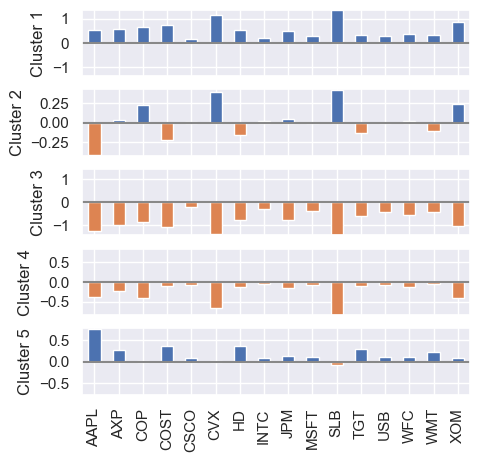

In [13]:
centers = pd.DataFrame(kmeans.cluster_centers_, columns=syms)

f, axes = plt.subplots(5, 1, figsize=(5, 5), sharex=True)
for i, ax in enumerate(axes):
    center = centers.loc[i, :]
    maxPC = 1.01 * np.max(np.max(np.abs(center)))
    colors = ['C0' if l > 0 else 'C1' for l in center]
    ax.axhline(color='#888888')
    center.plot.bar(ax=ax, color=colors)
    ax.set_ylabel(f'Cluster {i + 1}')
    ax.set_ylim(-maxPC, maxPC)

Above plot shows the centers of the clusters, which reveals the nature of each cluster. For example, clusters 3 and 1 correspond to days on which the market is down and up, respectively. Clusters 4 and 5 are characterized by up-market days for consumer stocks and down-market days for energy stocks, respectively. Finally, cluster 2 captures the days in which energy stocks were up and consumer stocks were down.

This plot is quite similar to the loadings of PCA. A major distinction is that unlike with PCA, the sign of the cluster means is meaningful. PCA identifies principal directions of variation, whereas cluster analysis finds groups of records located near one another.

### Selecting the Number of Clusters

A common approach, called the elbow method, is to identify when the set of clusters explains “most” of the variance in the data. Adding new clusters beyond this set contributes relatively little in the variance explained. The elbow is the point where the cumulative variance explained flattens out after rising steeply, hence the name of the method.

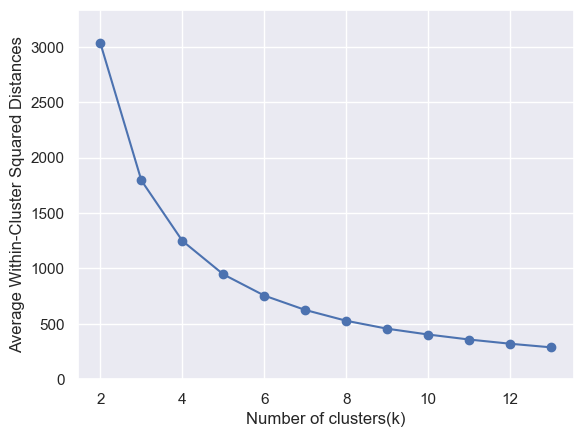

In [14]:
inertia = []
for n_clusters in range(2, 14):
    kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(top_sp)
    inertia.append(kmeans.inertia_ / n_clusters)

inertias = pd.DataFrame({'n_clusters': range(2, 14), 'inertia': inertia})
ax = inertias.plot(x='n_clusters', y='inertia', marker='o')
plt.xlabel('Number of clusters(k)')
plt.ylabel('Average Within-Cluster Squared Distances')
plt.ylim((0, 1.1 * inertias.inertia.max()))
ax.legend().set_visible(False)

In this case, there is no clear "elbow". In general, there is no single rule that will reliably guide how many clusters to produce.

## 7.3 Hierarchical Clustering

#### <center>Key Terms for Hierarchical Clustering</center>
- ***Dendrogram***  
A visual representation of the records and the hierarchy of clusters to which they belong.
- ***Distance***  
A measure of how close one record is to another.
- ***Dissimilarity***  
A measure of how close one cluster is to another.

Hierarchical clustering works on a data set with $n$ records and $p$ variables and is based on two basic building blocks:

- A distance metric $d_{i,j}$ to measure the distance between two records $i$ and $j$.
- A dissimilarity metric $D_{A,B}$ to measure the difference between two clusters $A$ and $B$ based on the distances $d_{i,j}$ between the members of each cluster.

For applications involving numeric data, the most importance choice is the dissimilarity metric. Hierarchical clustering starts by setting each record as its own cluster and iterates to combine the least dissimilar clusters.

Because hierarchical clustering operates on pairwise distance of all points, the computational cost is high especially with large data sets. As a result, most of the applications of hierarchical clustering are focused on relatively small data sets.


### Example

The following applies hierarchical clustering to the stock returns for a set of companies.

Clustering algorithms will cluster the records (rows) of a data frame. Since we want to cluster the companies, we need to *transpose* the data frame and put the stocks along the rows and the dates along the columns.

The `scipy` package offers a number of different methods for hierarchical clustering in the `scipy.cluster.hierarchy` module. Here we use the linkage function with the “complete” method:

In [15]:
syms1 = ['AAPL', 'AMZN', 'AXP', 'COP', 'COST', 'CSCO', 'CVX', 'GOOGL', 'HD',
         'INTC', 'JPM', 'MSFT', 'SLB', 'TGT', 'USB', 'WFC', 'WMT', 'XOM']
df = sp500_px.loc[sp500_px.index >= '2011-01-01', syms1].transpose()

Z = linkage(df, method='complete')

### The Dendrogram

Hierarchical clustering lends itself to a natural graphical display as a tree, referred to as a *dendrogram*.

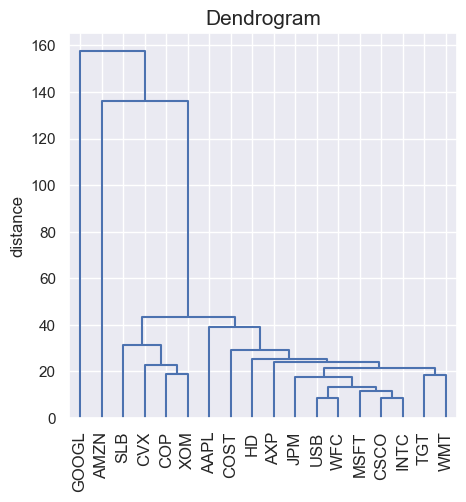

In [16]:
fig, ax = plt.subplots(figsize=(5, 5))
dendrogram(Z, labels=df.index, ax=ax, color_threshold=0)
plt.xticks(rotation=90, ha='center')
ax.set_ylabel('distance')
ax.set_title('Dendrogram', fontsize=15)
plt.show()

The result is shown above (note that we are now plotting companies that are
similar to one another, not days). The leaves of the tree correspond to the records. The length of the branch in the tree indicates the degree of dissimilarity between corresponding clusters. The returns for Google and Amazon are quite dissimilar to one another and to the returns for the other stocks. The oil stocks (SLB, CVX, XOM, COP) are in their own cluster, Apple (AAPL) is by itself, and the rest are similar to one another.

In contrast to K-means, it is not necessary to prespecify the number of clusters. Graphically, you can identify different numbers of clusters with a horizontal line that slides up or down; a cluster is defined wherever the horizontal line intersects the vertical lines.

In [17]:
memb = fcluster(Z, 4, criterion='maxclust')
memb = pd.Series(memb, index=df.index)
for key, item in memb.groupby(memb):
    print(f"{key} : {', '.join(item.index)}")

1 : COP, CVX, SLB, XOM
2 : AAPL, AXP, COST, CSCO, HD, INTC, JPM, MSFT, TGT, USB, WFC, WMT
3 : AMZN
4 : GOOGL


The number of clusters to extract is set to 4, and you can see that Google and Amazon each belong to their own cluster. The oil stocks all belong to another cluster. The remaining stocks are in the fourth cluster.

### The Agglomerative Algorithm

The main steps of the agglomerative algorithm are:  
1. Create an initial set of clusters with each cluster consisting of a single record for all records in the data.
2. Compute the dissimilarity $D(C_k,C_ℓ)$ between all pairs of clusters $k, ℓ$.
3. Merge the two clusters $C_k$ and $C_ℓ$ that are least dissimilar as measured by $D(C_k,C_ℓ)$.
4. If we have more than one cluster remaining, return to step 2. Otherwise, we are done.

### Measures of Dissimilartity

There are four common measures of dissimilarity.  
1. *Complete linkage*  
$D(A,B) = \text{max }d(a_i, b_j)\text{ for all pairs } i, j$
    - This method tends to produce clusters with members that are similar.
2. *Single linkage*  
$D(A,B) = \text{min }d(a_i, b_j)\text{ for all pairs } i, j$
    - This is a “greedy” method and produces clusters that can contain quite disparate elements.
3. *Average linkage*
    - It is the average of all distance pairs and represents a compromise between the single and complete linkage methods.
4. *Minimum variance*
    - Also referred to as *Ward’s* method, is similar to K-means since it minimizes the within-cluster sum of squares.

Below code applies hierarchical clustering using the four measures to the ExxonMobil and Chevron stock returns. For each measure, four clusters are retained.

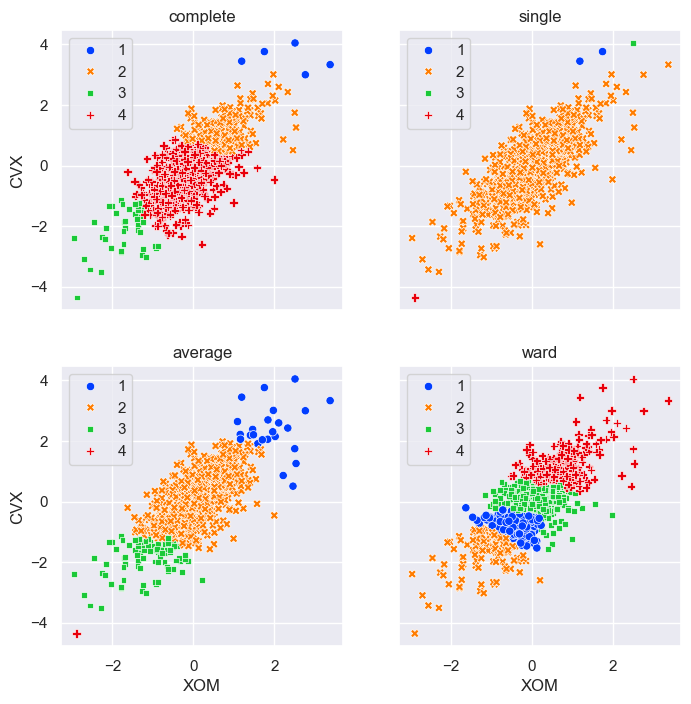

In [18]:
df = sp500_px.loc[sp500_px.index >= '2011-01-01', ['CVX', 'XOM']]
methods = ['complete', 'single', 'average', 'ward']

fig, axs = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(8,8))
for i in range(4):
    ax = axs[i//2, i%2]
    method = methods[i]
    Z = linkage(df, method=method)
    memb = fcluster(Z, 4, criterion='maxclust')
    sns.scatterplot(df, x='XOM', y='CVX', hue=memb, style=memb, 
                    palette='bright', ax=ax)
    ax.set_title(method)

The results are strikingly different: the single linkage measure assigns almost all of the points to a single cluster. Except for the minimum variance method (ward), all measures end up with at least one cluster with just a few outlying points. The minimum variance method is the most similar to the K-means cluster.

## 7.4 Model-Based Clustering

Simply speaking, model-based clustering is fitting statistical models (e.g. normal distribution) to the data, similar to peak fittings widely used in engineering tasks.

The most widely used model_based clustering methods rest on the *multivariate normal* distribution.

A multivariate normal distribution can be defined by the means of all the variables $\mu$ (center of the distribution) and the covariance matrix $\Sigma$ (variance and covariance between variables).

### Mistures of Normals

The key idea behind model-based clustering is that each record is assumed to be distributed as one of *K* multivariate normal distributions, where *K* is the number of clusters. Each distribution has a different mean $\mu$ and covariance matrix $\Sigma$.

Let's apply model-based clustering to the stock return data we previously analyzed using *K*-means and hierarchical clustering:

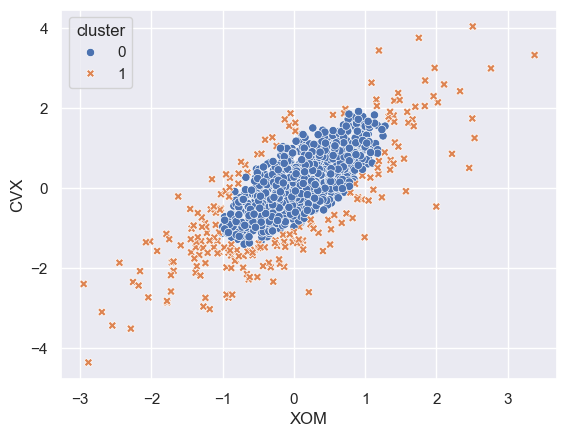

In [19]:
df = sp500_px.loc[sp500_px.index >= '2011-01-01', ['XOM', 'CVX']]
mclust = GaussianMixture(n_components=2).fit(df)
df['cluster'] = mclust.predict(df)
sns.scatterplot(df, x='XOM', y='CVX', hue='cluster', style='cluster')
plt.show()

There are two clusters: one cluster in the middle of the data, and a second cluster in the outer edge of the data. This is very different from the clusters obtained using K-means and hierarchical clustering, which find clusters that are compact.

Let's extract the parameters to the normal distributions

In [20]:
print('Mean')
print(pd.DataFrame(mclust.means_,
                   index=['XOM', 'CVX'],
                   columns=['Cluster 0', 'Cluster 1']))
print('\nCovariances')
print('  Cluster 0')
print(pd.DataFrame(mclust.covariances_[0],
                   index=['XOM', 'CVX'],
                   columns=['XOM', 'CVX']))
print('\n  Cluster 1')
print(pd.DataFrame(mclust.covariances_[1],
                   index=['XOM', 'CVX'],
                   columns=['XOM', 'CVX']))

Mean
     Cluster 0  Cluster 1
XOM   0.072470   0.104946
CVX  -0.050314  -0.211618

Covariances
  Cluster 0
          XOM       CVX
XOM  0.268227  0.275621
CVX  0.275621  0.516799

  Cluster 1
          XOM       CVX
XOM  0.971231  0.977643
CVX  0.977643  1.672338


The distributions have similar means and correlations, but the Cluster 0 distribution has much larger variances and covariances.

The clusters from `mclust` may seem surprising, but in fact, they illustrate the statistical nature of the method. The goal of model-based clustering is to find the best-fitting set of multivariate normal distributions. The stock data appears to have a normal looking shape. In fact, though, stock returns have a longer-tailed distribution than a normal distribution. To handle this, `mclust` fits a distribution to the bulk of the data but then fits a second distribution with a bigger variance.

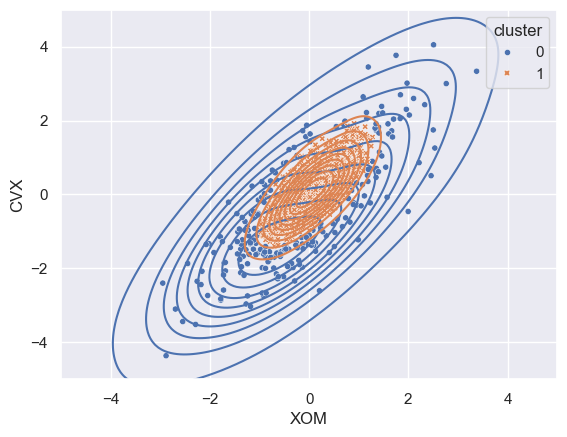

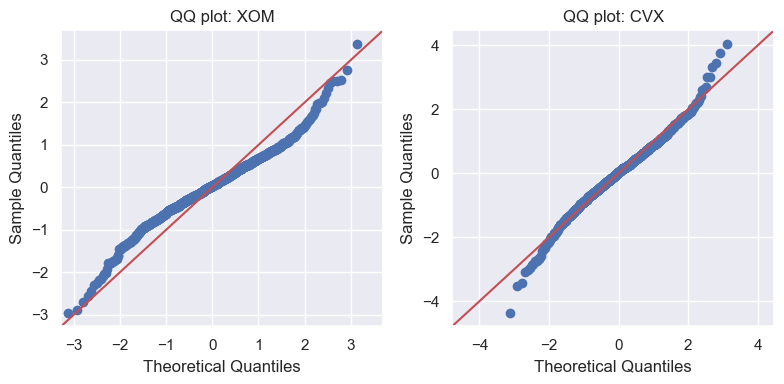

In [21]:
df = sp500_px.loc[sp500_px.index >= '2011-01-01', ['XOM', 'CVX']]
mclust = GaussianMixture(n_components=2).fit(df)
df['cluster'] = mclust.predict(df)
sns.scatterplot(df, x='XOM', y='CVX', hue='cluster', style='cluster',
                s=20)
sns.kdeplot(df[df['cluster']==0], x='XOM', y='CVX', bw_adjust=2)
sns.kdeplot(df[df['cluster']==1], x='XOM', y='CVX', bw_adjust=2)
plt.xlim(-5, 5)
plt.ylim(-5, 5)
plt.show()

fig, axs = plt.subplots(1, 2, figsize=(8, 4))
qqplot(df['XOM'], line='45', ax=axs[0])
qqplot(df['CVX'], line='45', ax=axs[1])
axs[0].set_title('QQ plot: XOM')
axs[1].set_title('QQ plot: CVX')
fig.tight_layout()
plt.show()

### Selecting the Number of Clusters

We can select the number of clusters by minimizing *Bayesian Information Criteria (BIC)*. BIC works by selecting the best-fitting model with a penalty for the number of parameters in the model. In the case of model-based clustering, adding more clusters will always improve the fit at the expense of introducing additional parameters in the model.

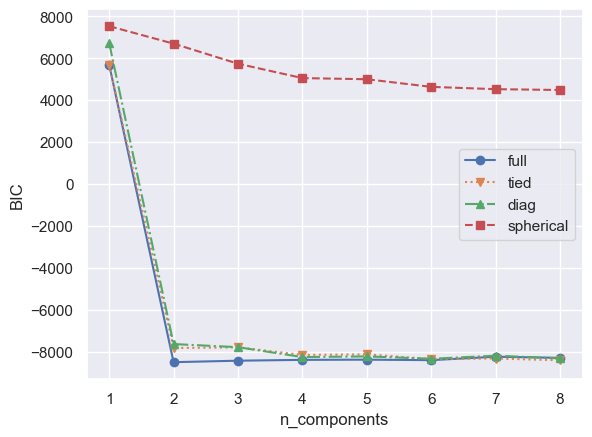

In [22]:
results = []
covariance_types = ['full', 'tied', 'diag', 'spherical']
for n_components in range(1, 9):
    for covariance_type in covariance_types:
        mclust = GaussianMixture(n_components=n_components, warm_start=True,
                                 covariance_type=covariance_type)
        mclust.fit(df)
        results.append({
            'bic': mclust.bic(df),
            'n_components': n_components,
            'covariance_type': covariance_type,
        })

results = pd.DataFrame(results)

colors = ['C0', 'C1', 'C2', 'C3']
styles = ['C0-','C1:','C2-.', 'C3--']
markers = ['o', 'v', '^', 's']

fig, ax = plt.subplots()
for i, covariance_type in enumerate(covariance_types):
    subset = results.loc[results.covariance_type == covariance_type, :]
    subset.plot(x='n_components', y='bic', ax=ax, label=covariance_type,
                kind='line', style=styles[i], marker=markers[i])
plt.ylabel('BIC')
plt.show()

This plot is similar to the elbow plot used to identify the number of clusters to choose for K-means, except the value being plotted is BIC instead of inertia. One big difference is that instead of one line, there are 4 lines here! This is because we are actually fitting 4 different models (different ways to parameterize the convariance matrix $\Sigma$ for fitting a model) for each cluster size, then choose the best-fitting model.

In this example, according to BIC, "full" model gives the best fit using two components.

## 7.5 Scaling and Categorical Variables

#### <center>Key Terms for Scaling Data</center>
- ***Scaling***  
Squashing or expanding data, usually to bring multiple variables to the same scale.
- ***Normalization***  
One method of scaling—subtracting the mean and dividing by the standard deviation.<br>  
*Synonym*
    - Standardization
- ***Gower’s distance***  
A scaling algorithm applied to mixed numeric and categorical data to bring all variables to a 0–1 range.

Unsupervised learning techniques generally require that the data be appropriately scaled. Otherwise the results will be dominated by the variables with large values.

### Categorical Data and Gower’s Distance

In the case of categorical data, you must convert it to numeric data, either by ranking (for an ordered factor) or by encoding as a set of binary (dummy) variables. If the data consists of mixed continuous and binary variables, you will usually want to scale the variables so that the ranges are similar.

One popular method is to use *Gower’s distance*. The basic idea behind Gower’s distance is to apply a different distance metric to each variable depending on the type of data:  
- For numeric variables and ordered factors, distance is calculated as the absolute value of the difference between two records (*Manhattan distance*).
- or categorical variables, the distance is 1 if the categories between two records are different, and the distance is 0 if the categories are the same.

Gower’s distance is computed as follows:  
1. Compute the distance $d_{i,j}$ for all pairs of variables $i$ and $j$ for each record.
2. Scale each pair $d_{i,j}$ so the minimum is 0 and the maximum is 1.
3. Add the pairwise scaled distances between variables together, using either a simple or a weighted mean, to create the distance matrix.